In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
import re
from tqdm import tqdm
import seaborn as sb
import pickle
import contractions as con
import string

tk = TreebankWordTokenizer()


In [2]:
# initiate pretrained vocabulary

class Vocabulary:
    def __init__(self):
        self.special_toks = ['<pad>','<sep>','<mask>','<unk>','<cls>']
        self.w2i = {'<pad>':0,'<sep>':2,'<mask>':1,'<unk>':3,'<cls>':4}
        self.i2w = {self.w2i[k]:k for k in self.w2i}
        self.size = len(self.special_toks)
        self.wc = {}
        
    def __call__(self,text):
        
        for sent in text:
            words = sent.split()
            for w in words:
                if w not in self.w2i:
                    self.w2i[w] = self.size
                    self.i2w[self.size] = w
                    self.size += 1
                    
                    self.wc[w] = 1
                    
                elif w not in self.special_toks:
                    self.wc[w] += 1
                    
        self.wc = dict(sorted(self.wc.items(), key=lambda x: x[1], reverse=True))
        
    def tokenize(self,seq):
        seq = seq.split()
        for i,w in enumerate(seq):
            if w not in self.w2i:
                seq[i] = 3
            else:
                seq[i] = self.w2i[w]
                
        return seq
                
    def add_padding(self,seq,maxlen):
        padding = [0]*(maxlen - len(seq))
        return seq + padding
    
if __name__ == "__main__":

    with open('vocab.pkl','rb') as f:
        vocab = pickle.load(f)

In [3]:
def clean_text(text):
    # Create a translation table that maps all punctuation characters to spaces
    text = [con.fix(w) for w in text.split()]
    text = ' '.join(text).lower()
    url_pattern = r'http\S+|www\S+'
    text = re.sub(url_pattern, '', text)
    
    # Use the translate method to replace punctuation with spaces
    translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    result_string = text.translate(translation_table)
    text = re.sub(r'\s+', ' ', result_string)
    text = tk.tokenize(text)
    text = [w for w in text if w.isalpha()]
    text = ' '.join(text)
    return text


In [4]:
df = pd.read_csv('IMDB Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.review = df.review.apply(lambda x: x.replace('<br />',' '))

In [6]:
%cd C:/Users/BJS/PycharmProjects/pythonProject1

C:\Users\BJS\PycharmProjects\pythonProject1


In [7]:
# tokenize sentences
df['sentences'] = df.review.apply(lambda x: sent_tokenize(x))

In [8]:
# clean text

sentences = []

for i in tqdm(df.index):
    tmp = []
    sents = df.sentences.loc[i]
    for sent in sents:
        tmp.append(clean_text(sent))
    sentences.append(tmp)
    


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:03<00:00, 781.53it/s]


In [9]:
sentences[10]

['phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines',
 'at first it was very odd and pretty funny but as the movie progressed i did not find the jokes or oddness funny anymore',
 'its a low budget film that is never a problem in itself there were some pretty interesting characters but eventually i just lost interest',
 'i imagine this film would appeal to a stoner who is currently partaking',
 'for something similar but better try brother from another planet']

In [10]:
# divide sentences in segemets

def create_segments(text, maxlen=200, seg_min_len=5, max_num_seg=2):
    text = [' '.join(x.split() + ['<sep>']) for x in text]
    text = ' '.join(text).split()
    text = text[:maxlen]
    if text[-1] != '<sep>':
        text[-1] = '<sep>'
    text = ' '.join(text)
    text = text.split('<sep>')
    text = [x.strip() for x in text if x != '']
    if len(text[-1].split()) < seg_min_len:
        text = text[:-1]
        
    text = ' <sep> '.join(text).split() + ['<sep>']
    
    
    if text.count('<sep>') > max_num_seg:
        text = ' '.join(text).split('<sep>')[:-1]
        n_seg = len(text) // max_num_seg + 1
        text = [re.sub(r'\s+', ' ',''.join(text[i:i+n_seg])).strip() for i in range(0,len(text),n_seg)]
        text =  ' <sep> '.join(text) + ' <sep>'
        text = text.split()
        text[0] = '<cls>'
        text = ' '.join(text)
    
    else:
        text = '<cls> ' + ' '.join(text)
       
    if len(text.split())>maxlen:
        text = text.split()
        text = text[:maxlen]
        text[-1] = '<sep>'
        return ' '.join(text)
    
    return text
    
maxlen = 200
n_seg = 2

segmented_sents = [create_segments(x,maxlen,max_num_seg=n_seg) for x in sentences]
segmented_sents[10]

'<cls> the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines at first it was very odd and pretty funny but as the movie progressed i did not find the jokes or oddness funny anymore its a low budget film that is never a problem in itself there were some pretty interesting characters but eventually i just lost interest <sep> i imagine this film would appeal to a stoner who is currently partaking for something similar but better try brother from another planet <sep>'

In [11]:
# split training and validation data

from sklearn.model_selection import train_test_split

y = df.sentiment.apply(lambda x: 1 if x == 'positive' else 0).values
xtrain,xval,ytrain,yval = train_test_split(segmented_sents,y,train_size=0.8,random_state=0)

In [12]:
# create segment embeddings

def create_segment_ids(text):
    seg = text.split()
    n_seg = seg.count('<sep>')-1
    
    for i,w in enumerate(seg[::-1]):
        seg[-i-1] = n_seg
        if w == '<sep>' and i>0:
            n_seg -= 1
            
    return seg
            

train_seg = [create_segment_ids(text) for text in xtrain]
val_seg = [create_segment_ids(text) for text in xval]


In [13]:
# tokenize text and add padding

xtrain = [vocab.tokenize(t) for t in xtrain]
xval = [vocab.tokenize(t) for t in xval]

xtrain = [vocab.add_padding(t,maxlen) for t in xtrain]
train_seg = [vocab.add_padding(t,maxlen) for t in train_seg]

xval = [vocab.add_padding(t,maxlen) for t in xval]
val_seg = [vocab.add_padding(t,maxlen) for t in val_seg]

xtrain = np.asarray(xtrain)
train_seg = np.asarray(train_seg)

xval = np.asarray(xval)
val_seg = np.asarray(val_seg)

In [14]:
# transformer positional encoding function

def positional_encoding(emb_dim,maxlen):
    pos = np.zeros((maxlen, emb_dim), dtype=np.float32)
    for p in range(maxlen):
        for i in range(emb_dim):
            if i % 2 == 0:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.sin(angle)
            else:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.cos(angle)
                
    return pos

<AxesSubplot: >

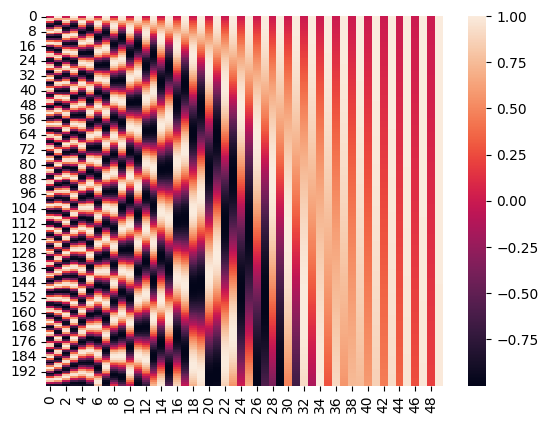

In [15]:
# define parameters

batch = 32
d_model = 128
n_heads = 8
units = d_model * 2
vocab_size = vocab.size
n_layers = 3
encodings = positional_encoding(d_model,maxlen)

sb.heatmap(encodings[:,:50])

In [16]:
# prepare data for model training

train = tf.data.Dataset.from_tensor_slices((xtrain,train_seg,ytrain))
train = train.batch(batch_size=batch, drop_remainder=True).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xval,val_seg,yval))
valid = valid.batch(batch_size=batch, drop_remainder=True).shuffle(buffer_size=100)

In [17]:
# build BERT model

from bert import BERT

i = Input((maxlen,),batch_size=batch, dtype=tf.int32)
seg = Input((maxlen,),batch_size=batch, dtype=tf.int32)
inputs = [i,seg]

bert_model = BERT(d_model=d_model, n_heads=n_heads, n_encoder_layer=n_layers,n_seg=n_seg, 
                  units=units, pos_weights=encodings, vocab_size=vocab_size)

out = bert_model(inputs)
out = GlobalAveragePooling1D()(out)
out = Dense(1,activation='sigmoid')(out)

model = tf.keras.Model(inputs,out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(32, 200)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(32, 200)]          0           []                               
                                                                                                  
 bert (BERT)                    (32, 200, 128)       12438016    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (32, 128)           0           ['bert[0][0]']               

In [18]:
# load pretrained weights 

model.layers[2].load_weights('mlm_bert.h5')
    

In [19]:

opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(x,y,w):
    with tf.GradientTape() as tape:
        pred = model(x, training=True)
        loss = loss_fn(y, pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss

@tf.function
def test_step(x,y,w):
    pred = model(x, training=False)
    loss = loss_fn(y, pred)
    return loss


<AxesSubplot: >

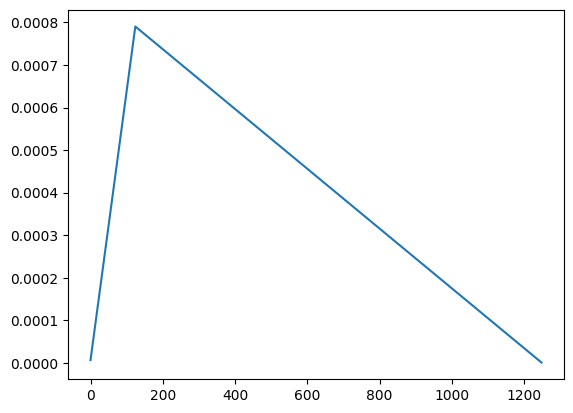

In [20]:
# linear lr warmup and decay scheduler

class CustomLRScheduler:
    def __init__(self,emb_size,end_lr,total_steps):
        self.emb_size = emb_size**-0.5
        self.end = end_lr
        self.total = total_steps
        self.warmup = total_steps//10
        self.decay = total_steps - self.warmup
        self.max = None
    
    def __call__(self,step,f=10):
        
        if step<=self.warmup:
            incr_rate = step*self.warmup**-1.5
            self.max = self.emb_size*incr_rate/f
            return self.emb_size*incr_rate/f
        else:
            step -= self.warmup
            lr_diff = self.max - self.end
            decay_rate = 1-step/self.decay
            return lr_diff * decay_rate + self.end
        

total_steps = len(xtrain)//batch
lr = 0

# visulaize lr change of custom scheduler
custom_lr_sch = CustomLRScheduler(d_model,lr,total_steps)
sb.lineplot([custom_lr_sch(s) for s in range(1,total_steps)])

In [21]:
# train BERT model for classification

losses = {"train":[],'valid':[]}
epochs = 3

for e in range(1,epochs+1):
    print(f'epochs : {e}/{epochs}')
    loss = 0
    for i,(x,s,y) in enumerate(tqdm(train)):
        w = x>0
        x = (x,s)
        lr = custom_lr_sch(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,w)
        
    loss = round(loss.numpy()/i, 4)
    
    print('train loss :',loss)
    
    losses['train'].append(loss)
    
    loss = 0
    for i,(x,s,y) in enumerate(valid):
        w = x>0
        x = (x,s)
        loss += test_step(x,y,w)
    
    loss = round(loss.numpy()/i, 4)
    print('val loss :',loss)
    
    if e == 1:
        model.save_weights('bert_best.h5')
        print('best weights saved')
    
    elif min(losses['valid']) > loss:
        model.save_weights('bert_best.h5')
        print('best weights saved')
        
    losses['valid'].append(loss)
    print()

epochs : 1/3


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [01:12<00:00, 17.31it/s]


train loss : 0.3819
val loss : 0.2958
best weights saved

epochs : 2/3


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [01:08<00:00, 18.13it/s]


train loss : 0.2415
val loss : 0.2834
best weights saved

epochs : 3/3


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [01:09<00:00, 18.08it/s]


train loss : 0.1392
val loss : 0.3051



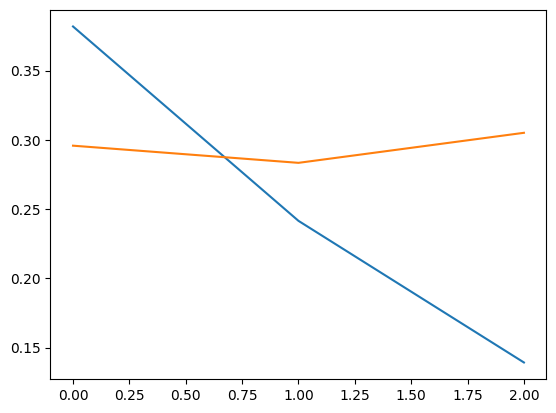

In [22]:
# plot train and val loss 
plt.plot(losses['train'])
plt.plot(losses['valid'])

In [23]:
# load the best model weights
model.load_weights('bert_best.h5')

In [24]:
# get predictions

num_batches = len(xval) // batch + 1
preds = []

for i in range(num_batches):
    seq = np.asarray(xval[i*batch:(i+1)*batch],dtype=np.int32)
    seg = np.asarray(val_seg[i*batch:(i+1)*batch],dtype=np.int32)
    pred = model([seq,seg])
    preds.extend(pred)

preds = [round(x.numpy()[0]) for x in preds]

In [25]:
# check different metrics

from sklearn.metrics import classification_report, f1_score, confusion_matrix,log_loss

print(classification_report(yval,preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5035
           1       0.87      0.88      0.88      4965

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [26]:
f1_score(yval,preds)

0.8791340950090198

In [27]:
log_loss(yval,preds)

4.165426567985102

<AxesSubplot: >

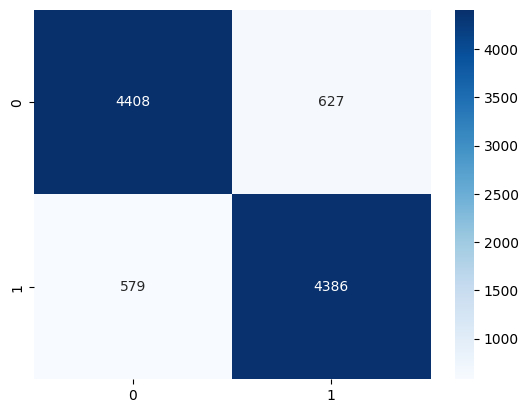

In [28]:
sb.heatmap(confusion_matrix(yval,preds),cmap='Blues',annot=True,fmt='d')

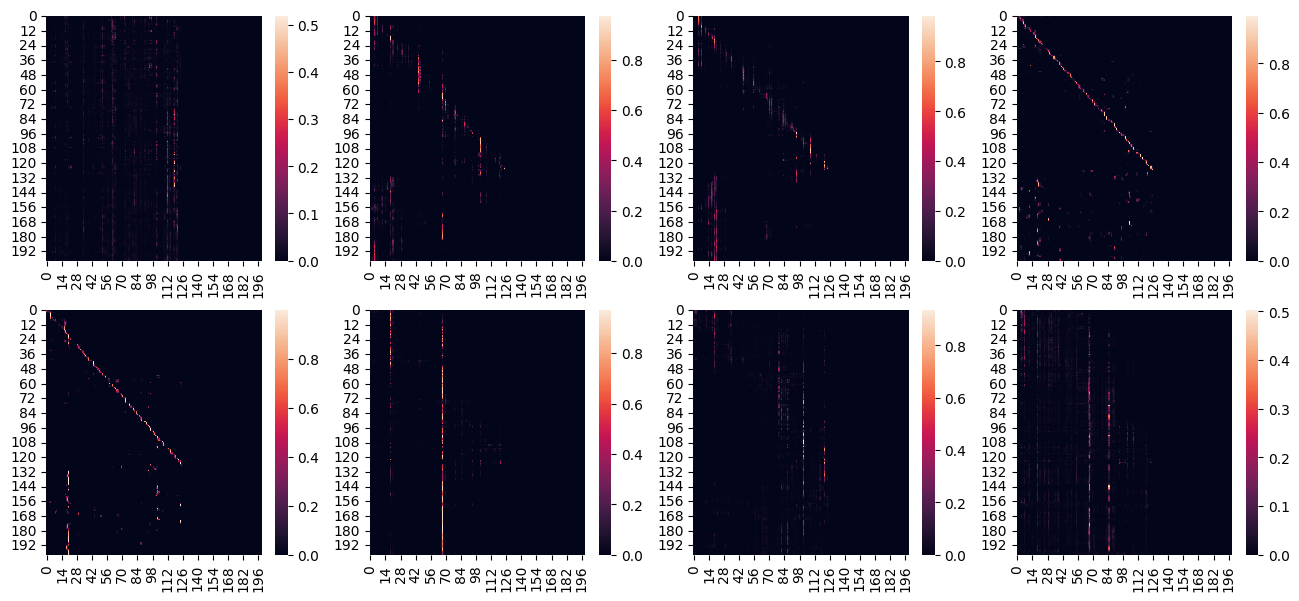

In [29]:
# plot attention scores of all 8 heads

_,ax = plt.subplots(2,4,figsize=(16,7))
for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[2].layers[1].mhsa.attention_scores[0].numpy(),
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
plt.show()